# Preprocesamiento de Datos - Formula 1 Machine Learning

## Objetivo

Este notebook implementa un pipeline completo de preprocesamiento de datos para los modelos de machine learning de Formula 1, incluyendo:

1. **Modelo de Regresión**: Predicción del tiempo promedio de vuelta
2. **Modelo de Clasificación**: Predicción de podio (Top 3)

## Contenido

1. Configuración del entorno
2. Carga de datos
3. Análisis de columnas clave para modelos
4. Limpieza de datos
5. Manejo de valores faltantes
6. Detección y manejo de duplicados
7. Feature engineering
8. Unión de tablas
9. Codificación de variables categóricas
10. Dataset final para modelado
11. Análisis de distribuciones finales
12. Guardado de datos procesados

## 1. Configuración del Entorno

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Librerías cargadas exitosamente")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

Librerías cargadas exitosamente
Pandas: 2.3.0
NumPy: 1.26.4


## 2. Carga de Datos

In [ ]:
# Definir rutas
DATA_PATH = '../data/01_raw/'
PROCESSED_PATH = '../data/03_primary/'

# Diccionario para datasets
datasets = {}

# Archivos clave para modelado
files_to_load = [
    'Race_Results.csv',
    'Qualifying_Results.csv',
    'Lap_Timings.csv',
    'Driver_Details.csv',
    'Team_Details.csv',
    'Race_Schedule.csv',
    'Track_Information.csv',
    'Pit_Stop_Records.csv',
    'Driver_Rankings.csv',
    'Constructor_Rankings.csv',
    'Race_Status.csv'
]

print("Cargando datasets para preprocesamiento...\\n")

for file in files_to_load:
    dataset_name = file.replace('.csv', '').lower()
    try:
        datasets[dataset_name] = pd.read_csv(DATA_PATH + file)
        print(f"[OK] {file} - {len(datasets[dataset_name]):,} registros, {datasets[dataset_name].shape[1]} columnas")
    except Exception as e:
        print(f"[ERROR] {file}: {e}")

print(f"\nTotal de datasets cargados: {len(datasets)}")
print(f"Memoria total utilizada: {sum(df.memory_usage(deep=True).sum() for df in datasets.values()) / 1024**2:.2f} MB")

Cargando datasets para preprocesamiento...\n
[OK] Race_Results.csv - 26,519 registros, 18 columnas
[OK] Qualifying_Results.csv - 10,254 registros, 9 columnas
[OK] Lap_Timings.csv - 575,029 registros, 6 columnas
[OK] Driver_Details.csv - 859 registros, 9 columnas
[OK] Team_Details.csv - 212 registros, 5 columnas
[OK] Race_Schedule.csv - 1,125 registros, 18 columnas
[OK] Track_Information.csv - 77 registros, 9 columnas
[OK] Pit_Stop_Records.csv - 10,990 registros, 7 columnas
[OK] Driver_Rankings.csv - 34,595 registros, 7 columnas
[OK] Constructor_Rankings.csv - 13,271 registros, 7 columnas
[OK] Race_Status.csv - 139 registros, 2 columnas

Total de datasets cargados: 11
Memoria total utilizada: 76.29 MB


## 3. Análisis de Columnas Clave para Modelos

In [32]:
# Definir columnas clave por dataset según objetivos de modelado

key_columns_mapping = {
    'race_results': {
        'keys': ['raceId', 'driverId', 'constructorId'],
        'features': ['grid', 'position', 'positionOrder', 'points', 'laps', 'milliseconds', 
                    'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId'],
        'target_regression': 'avg_lap_time',  # A calcular
        'target_classification': 'podium'     # A calcular (1 si posición <= 3)
    },
    'qualifying_results': {
        'keys': ['raceId', 'driverId', 'constructorId'],
        'features': ['position', 'q1', 'q2', 'q3']
    },
    'lap_timings': {
        'keys': ['raceId', 'driverId'],
        'features': ['lap', 'position', 'time', 'milliseconds']
    },
    'driver_details': {
        'keys': ['driverId'],
        'features': ['driverRef', 'code', 'nationality', 'dob']
    },
    'team_details': {
        'keys': ['constructorId'],
        'features': ['name', 'nationality']
    },
    'race_schedule': {
        'keys': ['raceId'],
        'features': ['year', 'round', 'circuitId', 'name', 'date']
    },
    'track_information': {
        'keys': ['circuitId'],
        'features': ['name', 'location', 'country', 'lat', 'lng', 'alt']
    },
    'pit_stop_records': {
        'keys': ['raceId', 'driverId'],
        'features': ['stop', 'lap', 'time', 'duration', 'milliseconds']
    }
}

print("COLUMNAS CLAVE IDENTIFICADAS PARA MODELADO")
print("=" * 80)

for dataset_name, config in key_columns_mapping.items():
    if dataset_name in datasets:
        df = datasets[dataset_name]
        available_keys = [col for col in config['keys'] if col in df.columns]
        available_features = [col for col in config['features'] if col in df.columns]
        
        print(f"\n{dataset_name.upper()}:")
        print(f"  Columnas clave: {available_keys}")
        print(f"  Features: {available_features}")
        
        missing_cols = set(config['keys'] + config['features']) - set(df.columns)
        if missing_cols:
            print(f"  FALTANTES: {list(missing_cols)}")

COLUMNAS CLAVE IDENTIFICADAS PARA MODELADO

RACE_RESULTS:
  Columnas clave: ['raceId', 'driverId', 'constructorId']
  Features: ['grid', 'position', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId']

QUALIFYING_RESULTS:
  Columnas clave: ['raceId', 'driverId', 'constructorId']
  Features: ['position', 'q1', 'q2', 'q3']

LAP_TIMINGS:
  Columnas clave: ['raceId', 'driverId']
  Features: ['lap', 'position', 'time', 'milliseconds']

DRIVER_DETAILS:
  Columnas clave: ['driverId']
  Features: ['driverRef', 'code', 'nationality', 'dob']

TEAM_DETAILS:
  Columnas clave: ['constructorId']
  Features: ['name', 'nationality']

RACE_SCHEDULE:
  Columnas clave: ['raceId']
  Features: ['year', 'round', 'circuitId', 'name', 'date']

TRACK_INFORMATION:
  Columnas clave: ['circuitId']
  Features: ['name', 'location', 'country', 'lat', 'lng', 'alt']

PIT_STOP_RECORDS:
  Columnas clave: ['raceId', 'driverId']
  Features: ['stop', 'lap', 'tim

## 4. Limpieza de Datos

### 4.1 Análisis de Calidad por Dataset

In [33]:
def analyze_data_quality(df, name):
    """Análisis detallado de calidad de datos"""
    print(f"\n{'='*80}")
    print(f"ANÁLISIS DE CALIDAD: {name.upper()}")
    print(f"{'='*80}")
    
    # Información básica
    print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    
    # Valores nulos
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0]
    
    if len(null_cols) > 0:
        print(f"\nValores nulos encontrados:")
        for col, count in null_cols.items():
            percentage = (count / len(df)) * 100
            print(f"  {col}: {count:,} ({percentage:.2f}%)")
    else:
        print("\nNo se encontraron valores nulos")
    
    # Duplicados
    duplicates = df.duplicated().sum()
    print(f"\nRegistros duplicados: {duplicates:,}")
    
    # Valores únicos por columna
    print(f"\nValores únicos por columna:")
    for col in df.columns[:10]:  # Primeras 10 columnas
        unique_count = df[col].nunique()
        unique_percentage = (unique_count / len(df)) * 100
        print(f"  {col}: {unique_count:,} ({unique_percentage:.1f}%)")
    
    if len(df.columns) > 10:
        print(f"  ... y {len(df.columns) - 10} columnas más")
    
    return {
        'null_counts': null_counts,
        'duplicates': duplicates,
        'shape': df.shape
    }

# Analizar calidad de datasets principales
quality_report = {}
main_datasets = ['race_results', 'qualifying_results', 'lap_timings', 'driver_details']

for dataset_name in main_datasets:
    if dataset_name in datasets:
        quality_report[dataset_name] = analyze_data_quality(datasets[dataset_name], dataset_name)


ANÁLISIS DE CALIDAD: RACE_RESULTS

Dimensiones: 26,519 filas × 18 columnas

No se encontraron valores nulos

Registros duplicados: 0

Valores únicos por columna:
  resultId: 26,519 (100.0%)
  raceId: 1,113 (4.2%)
  driverId: 859 (3.2%)
  constructorId: 211 (0.8%)
  number: 130 (0.5%)
  grid: 35 (0.1%)
  position: 34 (0.1%)
  positionText: 39 (0.1%)
  positionOrder: 39 (0.1%)
  points: 39 (0.1%)
  ... y 8 columnas más

ANÁLISIS DE CALIDAD: QUALIFYING_RESULTS

Dimensiones: 10,254 filas × 9 columnas

Valores nulos encontrados:
  q2: 13 (0.13%)
  q3: 27 (0.26%)

Registros duplicados: 0

Valores únicos por columna:
  qualifyId: 10,254 (100.0%)
  raceId: 482 (4.7%)
  driverId: 170 (1.7%)
  constructorId: 47 (0.5%)
  number: 55 (0.5%)
  position: 28 (0.3%)
  q1: 8,955 (87.3%)
  q2: 5,320 (51.9%)
  q3: 3,374 (32.9%)

ANÁLISIS DE CALIDAD: LAP_TIMINGS

Dimensiones: 575,029 filas × 6 columnas

No se encontraron valores nulos

Registros duplicados: 0

Valores únicos por columna:
  raceId: 531 (0.

### 4.2 Limpieza Específica por Dataset

In [34]:
# 4.2.1 Limpieza de Race Results
if 'race_results' in datasets:
    print("LIMPIEZA: RACE_RESULTS")
    print("="*50)
    
    df_race = datasets['race_results'].copy()
    original_count = len(df_race)
    
    # Convertir posiciones a numérico
    def clean_position(pos):
        """Limpia y convierte posiciones a numérico"""
        if pd.isna(pos):
            return np.nan
        pos_str = str(pos).strip()
        if pos_str.isdigit():
            return int(pos_str)
        elif pos_str in ['R', 'D', 'E', 'W', 'F', 'N']:
            return np.nan  # DNF, DSQ, etc.
        else:
            try:
                return int(pos_str)
            except:
                return np.nan
    
    df_race['position_clean'] = df_race['position'].apply(clean_position)
    
    # Convertir tiempos de milisegundos
    def clean_milliseconds(ms):
        """Limpia columna de milisegundos"""
        if pd.isna(ms) or ms == '\\N' or ms == '':
            return np.nan
        try:
            return int(ms)
        except:
            return np.nan
    
    df_race['milliseconds_clean'] = df_race['milliseconds'].apply(clean_milliseconds)
    
    # Crear variable objetivo de clasificación (podio)
    df_race['podium'] = (df_race['position_clean'] <= 3).astype(int)
    df_race.loc[df_race['position_clean'].isna(), 'podium'] = 0  # No podio si no terminó
    
    # Filtrar solo carreras con posición válida para algunos análisis
    df_race_finished = df_race[df_race['position_clean'].notna()].copy()
    
    print(f"Registros originales: {original_count:,}")
    print(f"Registros con posición válida: {len(df_race_finished):,}")
    print(f"Registros con podio: {df_race['podium'].sum():,}")
    print(f"Tasa de podio: {(df_race['podium'].sum() / len(df_race_finished) * 100):.2f}%")
    
    datasets['race_results'] = df_race

LIMPIEZA: RACE_RESULTS
Registros originales: 26,519
Registros con posición válida: 15,591
Registros con podio: 3,360
Tasa de podio: 21.55%


In [35]:
# 4.2.2 Limpieza de Qualifying Results
if 'qualifying_results' in datasets:
    print("\nLIMPIEZA: QUALIFYING_RESULTS")
    print("="*50)
    
    df_qual = datasets['qualifying_results'].copy()
    
    # Función para convertir tiempos MM:SS.sss a segundos
    def time_to_seconds(time_str):
        """Convierte formato MM:SS.sss a segundos totales"""
        if pd.isna(time_str) or time_str == '\\N' or time_str == '':
            return np.nan
        try:
            time_str = str(time_str).strip()
            if ':' in time_str:
                parts = time_str.split(':')
                if len(parts) == 2:
                    minutes = float(parts[0])
                    seconds = float(parts[1])
                    return minutes * 60 + seconds
            return float(time_str)  # Ya está en segundos
        except:
            return np.nan
    
    # Convertir tiempos de clasificación
    for session in ['q1', 'q2', 'q3']:
        if session in df_qual.columns:
            df_qual[f'{session}_seconds'] = df_qual[session].apply(time_to_seconds)
    
    # Calcular tiempo promedio de clasificación (cuando esté disponible)
    time_cols = [col for col in ['q1_seconds', 'q2_seconds', 'q3_seconds'] if col in df_qual.columns]
    if time_cols:
        df_qual['avg_qualifying_time'] = df_qual[time_cols].mean(axis=1, skipna=True)
        df_qual['best_qualifying_time'] = df_qual[time_cols].min(axis=1, skipna=True)
    
    print(f"Registros procesados: {len(df_qual):,}")
    print(f"Q1 válidos: {df_qual['q1_seconds'].notna().sum():,}")
    print(f"Q2 válidos: {df_qual['q2_seconds'].notna().sum():,}")
    print(f"Q3 válidos: {df_qual['q3_seconds'].notna().sum():,}")
    
    datasets['qualifying_results'] = df_qual


LIMPIEZA: QUALIFYING_RESULTS
Registros procesados: 10,254
Q1 válidos: 10,100
Q2 válidos: 5,669
Q3 válidos: 3,514


In [36]:
# 4.2.3 Limpieza de Lap Timings
if 'lap_timings' in datasets:
    print("\nLIMPIEZA: LAP_TIMINGS")
    print("="*50)
    
    df_laps = datasets['lap_timings'].copy()
    original_count = len(df_laps)
    
    # Convertir milisegundos a segundos
    df_laps['seconds'] = df_laps['milliseconds'] / 1000
    
    # Filtrar valores extremos (probables errores o safety cars)
    # Tiempo mínimo razonable: 50 segundos
    # Tiempo máximo razonable: 300 segundos (5 minutos)
    df_laps_clean = df_laps[
        (df_laps['seconds'] >= 50) & 
        (df_laps['seconds'] <= 300)
    ].copy()
    
    print(f"Registros originales: {original_count:,}")
    print(f"Registros después de filtrar extremos: {len(df_laps_clean):,}")
    print(f"Registros eliminados: {original_count - len(df_laps_clean):,} ({((original_count - len(df_laps_clean))/original_count*100):.2f}%)")
    print(f"Tiempo promedio: {df_laps_clean['seconds'].mean():.2f} segundos")
    print(f"Tiempo mediano: {df_laps_clean['seconds'].median():.2f} segundos")
    
    datasets['lap_timings'] = df_laps_clean


LIMPIEZA: LAP_TIMINGS
Registros originales: 575,029
Registros después de filtrar extremos: 574,337
Registros eliminados: 692 (0.12%)
Tiempo promedio: 93.74 segundos
Tiempo mediano: 90.60 segundos


In [37]:
# 4.2.4 Limpieza de Driver Details
if 'driver_details' in datasets:
    print("\nLIMPIEZA: DRIVER_DETAILS")
    print("="*50)
    
    df_drivers = datasets['driver_details'].copy()
    
    # Convertir fecha de nacimiento
    df_drivers['dob'] = pd.to_datetime(df_drivers['dob'], errors='coerce')
    
    # Calcular edad al momento actual (será recalculado por carrera después)
    current_date = datetime.now()
    df_drivers['age_current'] = (current_date - df_drivers['dob']).dt.days / 365.25
    
    # Limpiar nacionalidades (estandarizar)
    nationality_mapping = {
        'British': 'United Kingdom',
        'American': 'USA',
        'German': 'Germany',
        'Brazilian': 'Brazil',
        'Italian': 'Italy',
        'French': 'France',
        'Spanish': 'Spain',
        'Dutch': 'Netherlands',
        'Finnish': 'Finland',
        'Austrian': 'Austria'
    }
    
    df_drivers['nationality_clean'] = df_drivers['nationality'].replace(nationality_mapping)
    
    print(f"Registros procesados: {len(df_drivers):,}")
    print(f"Fechas de nacimiento válidas: {df_drivers['dob'].notna().sum():,}")
    print(f"Nacionalidades únicas: {df_drivers['nationality_clean'].nunique()}")
    print(f"Rango de edades: {df_drivers['age_current'].min():.1f} - {df_drivers['age_current'].max():.1f} años")
    
    datasets['driver_details'] = df_drivers


LIMPIEZA: DRIVER_DETAILS
Registros procesados: 859
Fechas de nacimiento válidas: 859
Nacionalidades únicas: 42
Rango de edades: 20.4 - 128.7 años


## 5. Manejo de Valores Faltantes

### 5.1 Análisis de Patrones de Datos Faltantes

In [38]:
def analyze_missing_patterns(df, name):
    """Analiza patrones de datos faltantes"""
    print(f"\nPATRONES DE DATOS FALTANTES: {name.upper()}")
    print("-" * 60)
    
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    
    if len(missing_data) == 0:
        print("No hay datos faltantes en este dataset")
        return None
    
    print(f"Columnas con datos faltantes:")
    for col, count in missing_data.items():
        percentage = (count / len(df)) * 100
        print(f"  {col}: {count:,} ({percentage:.2f}%)")
    
    return missing_data

# Analizar patrones de datos faltantes
missing_patterns = {}
for name, df in datasets.items():
    if len(df) > 0:
        pattern = analyze_missing_patterns(df, name)
        if pattern is not None:
            missing_patterns[name] = pattern


PATRONES DE DATOS FALTANTES: RACE_RESULTS
------------------------------------------------------------
Columnas con datos faltantes:
  milliseconds_clean: 18,986 (71.59%)
  position_clean: 10,928 (41.21%)

PATRONES DE DATOS FALTANTES: QUALIFYING_RESULTS
------------------------------------------------------------
Columnas con datos faltantes:
  q3_seconds: 6,740 (65.73%)
  q2_seconds: 4,585 (44.71%)
  q1_seconds: 154 (1.50%)
  avg_qualifying_time: 154 (1.50%)
  best_qualifying_time: 154 (1.50%)
  q3: 27 (0.26%)
  q2: 13 (0.13%)

PATRONES DE DATOS FALTANTES: LAP_TIMINGS
------------------------------------------------------------
No hay datos faltantes en este dataset

PATRONES DE DATOS FALTANTES: DRIVER_DETAILS
------------------------------------------------------------
No hay datos faltantes en este dataset

PATRONES DE DATOS FALTANTES: TEAM_DETAILS
------------------------------------------------------------
No hay datos faltantes en este dataset

PATRONES DE DATOS FALTANTES: RACE_

### 5.2 Imputación de Valores Faltantes

In [39]:
# 5.2.1 Imputación en Qualifying Results
if 'qualifying_results' in datasets and 'qualifying_results' in missing_patterns:
    print("IMPUTACIÓN: QUALIFYING_RESULTS")
    print("="*50)
    
    df_qual = datasets['qualifying_results'].copy()
    
    # Identificar columnas numéricas para KNN
    numeric_cols = ['position', 'q1_seconds', 'q2_seconds', 'q3_seconds']
    available_numeric = [col for col in numeric_cols if col in df_qual.columns]
    
    if len(available_numeric) > 1:
        # Aplicar KNN Imputer
        knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
        
        # Solo imputar si hay suficientes datos
        subset_data = df_qual[available_numeric].copy()
        
        # Imputar solo si el porcentaje de faltantes es razonable (< 50%)
        for col in available_numeric:
            missing_pct = df_qual[col].isnull().sum() / len(df_qual) * 100
            if 0 < missing_pct < 50:  # Solo imputar si hay algunos faltantes pero no demasiados
                print(f"Imputando {col} (faltantes: {missing_pct:.1f}%)")
                
                # Crear dataset temporal para imputación
                temp_data = df_qual[['raceId', 'driverId'] + available_numeric].copy()
                
                # Aplicar KNN solo a las columnas de tiempo
                time_cols = [c for c in available_numeric if 'seconds' in c]
                if len(time_cols) > 0 and col in time_cols:
                    imputed_values = knn_imputer.fit_transform(subset_data)
                    imputed_df = pd.DataFrame(imputed_values, columns=available_numeric, index=subset_data.index)
                    df_qual[col] = imputed_df[col]
    
    # Verificar resultado
    print("\nResultado de imputación:")
    for col in available_numeric:
        missing_after = df_qual[col].isnull().sum()
        print(f"  {col}: {missing_after} valores faltantes restantes")
    
    datasets['qualifying_results'] = df_qual

IMPUTACIÓN: QUALIFYING_RESULTS
Imputando q1_seconds (faltantes: 1.5%)
Imputando q2_seconds (faltantes: 44.7%)

Resultado de imputación:
  position: 0 valores faltantes restantes
  q1_seconds: 0 valores faltantes restantes
  q2_seconds: 0 valores faltantes restantes
  q3_seconds: 6740 valores faltantes restantes


## 6. Detección y Manejo de Duplicados

In [40]:
def handle_duplicates(df, name, key_columns=None):
    """Maneja duplicados en un dataset"""
    print(f"\nMANEJO DE DUPLICADOS: {name.upper()}")
    print("-" * 60)
    
    original_count = len(df)
    
    # Duplicados completos
    complete_duplicates = df.duplicated().sum()
    print(f"Duplicados completos: {complete_duplicates:,}")
    
    if complete_duplicates > 0:
        df_clean = df.drop_duplicates()
        print(f"Registros después de eliminar duplicados completos: {len(df_clean):,}")
    else:
        df_clean = df.copy()
    
    # Duplicados por columnas clave (si se especifican)
    if key_columns:
        available_keys = [col for col in key_columns if col in df_clean.columns]
        if available_keys:
            key_duplicates = df_clean.duplicated(subset=available_keys).sum()
            print(f"Duplicados por columnas clave {available_keys}: {key_duplicates:,}")
            
            if key_duplicates > 0:
                # Mantener el primer registro de cada grupo
                df_clean = df_clean.drop_duplicates(subset=available_keys, keep='first')
                print(f"Registros después de eliminar duplicados por clave: {len(df_clean):,}")
    
    removed_count = original_count - len(df_clean)
    if removed_count > 0:
        print(f"Total de registros eliminados: {removed_count:,} ({removed_count/original_count*100:.2f}%)")
    
    return df_clean

# Manejar duplicados en datasets principales
duplicate_handling = {
    'race_results': ['resultId'],
    'qualifying_results': ['qualifyId'],
    'lap_timings': ['raceId', 'driverId', 'lap'],
    'driver_details': ['driverId'],
    'team_details': ['constructorId'],
    'pit_stop_records': ['raceId', 'driverId', 'stop']
}

for dataset_name, key_cols in duplicate_handling.items():
    if dataset_name in datasets:
        datasets[dataset_name] = handle_duplicates(
            datasets[dataset_name], 
            dataset_name, 
            key_cols
        )


MANEJO DE DUPLICADOS: RACE_RESULTS
------------------------------------------------------------
Duplicados completos: 0
Duplicados por columnas clave ['resultId']: 0

MANEJO DE DUPLICADOS: QUALIFYING_RESULTS
------------------------------------------------------------
Duplicados completos: 0
Duplicados por columnas clave ['qualifyId']: 0

MANEJO DE DUPLICADOS: LAP_TIMINGS
------------------------------------------------------------
Duplicados completos: 0
Duplicados por columnas clave ['raceId', 'driverId', 'lap']: 0

MANEJO DE DUPLICADOS: DRIVER_DETAILS
------------------------------------------------------------
Duplicados completos: 0
Duplicados por columnas clave ['driverId']: 0

MANEJO DE DUPLICADOS: TEAM_DETAILS
------------------------------------------------------------
Duplicados completos: 0
Duplicados por columnas clave ['constructorId']: 0

MANEJO DE DUPLICADOS: PIT_STOP_RECORDS
------------------------------------------------------------
Duplicados completos: 0
Duplicados

## 7. Feature Engineering

### 7.1 Creación de Variables de Rendimiento Histórico

In [41]:
# 7.1.1 Calcular estadísticas de tiempo de vuelta por piloto/carrera
if 'lap_timings' in datasets:
    print("FEATURE ENGINEERING: ESTADÍSTICAS DE TIEMPO DE VUELTA")
    print("="*60)
    
    df_laps = datasets['lap_timings']
    
    # Calcular estadísticas por carrera-piloto
    lap_stats = df_laps.groupby(['raceId', 'driverId']).agg({
        'seconds': ['mean', 'min', 'max', 'std', 'count'],
        'position': ['mean', 'min', 'max']
    }).round(3)
    
    # Aplanar columnas multinivel
    lap_stats.columns = ['_'.join(col).strip() for col in lap_stats.columns]
    lap_stats = lap_stats.reset_index()
    
    # Renombrar columnas para claridad
    rename_mapping = {
        'seconds_mean': 'avg_lap_time',
        'seconds_min': 'fastest_lap_time',
        'seconds_max': 'slowest_lap_time',
        'seconds_std': 'lap_time_consistency',
        'seconds_count': 'total_laps',
        'position_mean': 'avg_position_in_race',
        'position_min': 'best_position_in_race',
        'position_max': 'worst_position_in_race'
    }
    
    lap_stats = lap_stats.rename(columns=rename_mapping)
    
    print(f"Estadísticas calculadas para {len(lap_stats):,} combinaciones carrera-piloto")
    print(f"Columnas creadas: {list(rename_mapping.values())}")
    
    # Guardar estadísticas para uso posterior
    datasets['lap_statistics'] = lap_stats

FEATURE ENGINEERING: ESTADÍSTICAS DE TIEMPO DE VUELTA
Estadísticas calculadas para 10,788 combinaciones carrera-piloto
Columnas creadas: ['avg_lap_time', 'fastest_lap_time', 'slowest_lap_time', 'lap_time_consistency', 'total_laps', 'avg_position_in_race', 'best_position_in_race', 'worst_position_in_race']


In [42]:
# 7.1.2 Calcular rendimiento histórico reciente por piloto
if 'race_results' in datasets and 'race_schedule' in datasets:
    print("\nFEATURE ENGINEERING: RENDIMIENTO HISTÓRICO")
    print("="*60)
    
    # Combinar resultados con fechas de carrera
    df_race = datasets['race_results'].merge(
        datasets['race_schedule'][['raceId', 'year', 'round', 'date']],
        on='raceId', how='left'
    )
    
    # Convertir fecha
    df_race['date'] = pd.to_datetime(df_race['date'], errors='coerce')
    
    # Ordenar por piloto y fecha
    df_race = df_race.sort_values(['driverId', 'date'])
    
    # Calcular métricas móviles para las últimas N carreras
    def calculate_rolling_stats(group, window=3):
        """Calcula estadísticas móviles para un piloto"""
        group = group.sort_values('date')
        
        # Posición promedio en últimas N carreras
        group[f'avg_position_last_{window}'] = group['position_clean'].rolling(
            window=window, min_periods=1
        ).mean().shift(1)  # shift(1) para evitar data leakage
        
        # Puntos promedio en últimas N carreras
        group[f'avg_points_last_{window}'] = group['points'].rolling(
            window=window, min_periods=1
        ).mean().shift(1)
        
        # Podios en últimas N carreras
        group[f'podiums_last_{window}'] = group['podium'].rolling(
            window=window, min_periods=1
        ).sum().shift(1)
        
        # DNFs en últimas N carreras
        group[f'dnfs_last_{window}'] = group['position_clean'].isna().rolling(
            window=window, min_periods=1
        ).sum().shift(1)
        
        return group
    
    # Aplicar cálculos por piloto
    df_race_enhanced = df_race.groupby('driverId').apply(
        lambda x: calculate_rolling_stats(x, window=3)
    ).reset_index(drop=True)
    
    # Calcular estadísticas de carrera (experiencia)
    df_race_enhanced['driver_race_count'] = df_race_enhanced.groupby('driverId').cumcount()
    
    print(f"Variables de rendimiento histórico creadas:")
    historical_vars = [col for col in df_race_enhanced.columns if 'last_' in col or 'driver_race_count' in col]
    for var in historical_vars:
        print(f"  - {var}")
    
    datasets['race_results_enhanced'] = df_race_enhanced


FEATURE ENGINEERING: RENDIMIENTO HISTÓRICO
Variables de rendimiento histórico creadas:
  - avg_position_last_3
  - avg_points_last_3
  - podiums_last_3
  - dnfs_last_3
  - driver_race_count


### 7.2 Variables de Constructor/Equipo

In [43]:
# 7.2.1 Rendimiento del constructor por temporada
if 'constructor_rankings' in datasets:
    print("FEATURE ENGINEERING: RENDIMIENTO DE CONSTRUCTORES")
    print("="*60)
    
    df_const_rank = datasets['constructor_rankings']
    
    # Combinar con información de carrera para obtener año
    if 'race_schedule' in datasets:
        df_const_enhanced = df_const_rank.merge(
            datasets['race_schedule'][['raceId', 'year']],
            on='raceId', how='left'
        )
        
        # Calcular estadísticas del constructor por año
        constructor_yearly_stats = df_const_enhanced.groupby(['constructorId', 'year']).agg({
            'points': ['sum', 'mean'],
            'position': ['mean', 'min'],
            'wins': 'sum'
        }).round(3)
        
        constructor_yearly_stats.columns = ['_'.join(col).strip() for col in constructor_yearly_stats.columns]
        constructor_yearly_stats = constructor_yearly_stats.reset_index()
        
        rename_const = {
            'points_sum': 'constructor_total_points',
            'points_mean': 'constructor_avg_points',
            'position_mean': 'constructor_avg_position',
            'position_min': 'constructor_best_position',
            'wins_sum': 'constructor_total_wins'
        }
        
        constructor_yearly_stats = constructor_yearly_stats.rename(columns=rename_const)
        
        print(f"Estadísticas de constructor calculadas para {len(constructor_yearly_stats):,} combinaciones constructor-año")
        
        datasets['constructor_yearly_stats'] = constructor_yearly_stats

FEATURE ENGINEERING: RENDIMIENTO DE CONSTRUCTORES
Estadísticas de constructor calculadas para 920 combinaciones constructor-año


### 7.3 Variables de Circuito y Pistas

In [44]:
# 7.3.1 Rendimiento histórico por circuito
if 'race_results_enhanced' in datasets and 'race_schedule' in datasets:
    print("\nFEATURE ENGINEERING: RENDIMIENTO POR CIRCUITO")
    print("="*60)
    
    df_race_circ = datasets['race_results_enhanced'].merge(
        datasets['race_schedule'][['raceId', 'circuitId']],
        on='raceId', how='left'
    )
    
    # Calcular estadísticas históricas por piloto-circuito
    def calculate_circuit_stats(group):
        """Calcula estadísticas de rendimiento por circuito para cada piloto"""
        group = group.sort_values('date')
        
        # Carreras acumuladas en ese circuito
        group['races_at_circuit'] = group.groupby(['driverId', 'circuitId']).cumcount()
        
        # Promedio de posición en el circuito hasta la carrera anterior
        group['avg_position_at_circuit'] = (
            group.groupby(['driverId', 'circuitId'])['position_clean']
                 .transform(lambda x: x.expanding().mean().shift(1))
        )
        
        # Podios acumulados hasta la carrera anterior
        group['podiums_at_circuit'] = (
            group.groupby(['driverId', 'circuitId'])['podium']
                 .transform(lambda x: x.expanding().sum().shift(1))
        )
        
        # Victorias acumuladas hasta la carrera anterior
        group['wins_at_circuit'] = (
            group.groupby(['driverId', 'circuitId'])['position_clean']
                 .transform(lambda x: (x == 1).expanding().sum().shift(1))
        )
        
        return group

    
    df_circuit_enhanced = calculate_circuit_stats(df_race_circ)
    
    # Rellenar NaN para primeras carreras en un circuito
    circuit_vars = ['races_at_circuit', 'avg_position_at_circuit', 'podiums_at_circuit', 'wins_at_circuit']
    for var in circuit_vars:
        df_circuit_enhanced[var] = df_circuit_enhanced[var].fillna(0)
    
    print(f"Variables de circuito creadas: {circuit_vars}")
    
    datasets['race_results_circuit'] = df_circuit_enhanced


FEATURE ENGINEERING: RENDIMIENTO POR CIRCUITO
Variables de circuito creadas: ['races_at_circuit', 'avg_position_at_circuit', 'podiums_at_circuit', 'wins_at_circuit']


## 8. Unión de Tablas

### 8.1 Crear Dataset Master para Modelado

In [45]:
# 8.1 Crear dataset principal unificado
print("CREACIÓN DE DATASET UNIFICADO")
print("="*60)

# Comenzar con race_results como base
if 'race_results_circuit' in datasets:
    df_master = datasets['race_results_circuit'].copy()
    print(f"Base de datos: race_results_circuit con {len(df_master):,} registros")
else:
    df_master = datasets['race_results_enhanced'].copy()
    print(f"Base de datos: race_results_enhanced con {len(df_master):,} registros")

original_cols = len(df_master.columns)

# 8.1.1 Unir con estadísticas de lap timings
if 'lap_statistics' in datasets:
    df_master = df_master.merge(
        datasets['lap_statistics'],
        on=['raceId', 'driverId'],
        how='left'
    )
    print(f"[OK] Estadísticas de vuelta añadidas: {len(datasets['lap_statistics']):,} registros")

# 8.1.2 Unir con resultados de clasificación
if 'qualifying_results' in datasets:
    qualifying_cols = ['raceId', 'driverId', 'position', 'q1_seconds', 'q2_seconds', 'q3_seconds', 
                      'avg_qualifying_time', 'best_qualifying_time']
    available_qual_cols = ['raceId', 'driverId'] + [col for col in qualifying_cols[2:] 
                                                    if col in datasets['qualifying_results'].columns]
    
    df_master = df_master.merge(
        datasets['qualifying_results'][available_qual_cols].rename(columns={'position': 'qualifying_position'}),
        on=['raceId', 'driverId'],
        how='left'
    )
    print(f"[OK] Resultados de clasificación añadidos: {len(datasets['qualifying_results']):,} registros")

# 8.1.3 Unir con detalles del piloto
if 'driver_details' in datasets:
    driver_cols = ['driverId', 'nationality_clean', 'age_current']
    available_driver_cols = [col for col in driver_cols if col in datasets['driver_details'].columns]
    
    df_master = df_master.merge(
        datasets['driver_details'][available_driver_cols],
        on='driverId',
        how='left'
    )
    print(f"[OK] Detalles del piloto añadidos: {len(datasets['driver_details']):,} registros")

# 8.1.4 Unir con detalles del constructor
if 'team_details' in datasets:
    team_cols = ['constructorId', 'name', 'nationality']
    available_team_cols = [col for col in team_cols if col in datasets['team_details'].columns]
    
    df_master = df_master.merge(
        datasets['team_details'][available_team_cols].rename(columns={
            'name': 'constructor_name',
            'nationality': 'constructor_nationality'
        }),
        on='constructorId',
        how='left'
    )
    print(f"[OK] Detalles del constructor añadidos: {len(datasets['team_details']):,} registros")

# 8.1.5 Unir con información del circuito
if 'track_information' in datasets and 'race_schedule' in datasets:
    # Primero obtener circuitId de race_schedule si no está ya
    if 'circuitId' not in df_master.columns:
        df_master = df_master.merge(
            datasets['race_schedule'][['raceId', 'circuitId']],
            on='raceId',
            how='left'
        )
    
    # Luego añadir información del circuito
    circuit_cols = ['circuitId', 'name', 'location', 'country', 'lat', 'lng', 'alt']
    available_circuit_cols = [col for col in circuit_cols if col in datasets['track_information'].columns]
    
    df_master = df_master.merge(
        datasets['track_information'][available_circuit_cols].rename(columns={
            'name': 'circuit_name',
            'location': 'circuit_location',
            'country': 'circuit_country'
        }),
        on='circuitId',
        how='left'
    )
    print(f"[OK] Información del circuito añadida: {len(datasets['track_information']):,} registros")

# 8.1.6 Unir con estadísticas anuales del constructor
if 'constructor_yearly_stats' in datasets:
    df_master = df_master.merge(
        datasets['constructor_yearly_stats'],
        on=['constructorId', 'year'],
        how='left'
    )
    print(f"[OK] Estadísticas anuales del constructor añadidas: {len(datasets['constructor_yearly_stats']):,} registros")

final_cols = len(df_master.columns)
print(f"\nDataset unificado creado:")
print(f"  - Registros: {len(df_master):,}")
print(f"  - Columnas originales: {original_cols}")
print(f"  - Columnas finales: {final_cols}")
print(f"  - Nuevas columnas: {final_cols - original_cols}")

CREACIÓN DE DATASET UNIFICADO
Base de datos: race_results_circuit con 26,519 registros
[OK] Estadísticas de vuelta añadidas: 10,788 registros
[OK] Resultados de clasificación añadidos: 10,254 registros
[OK] Detalles del piloto añadidos: 859 registros
[OK] Detalles del constructor añadidos: 212 registros
[OK] Información del circuito añadida: 77 registros
[OK] Estadísticas anuales del constructor añadidas: 920 registros

Dataset unificado creado:
  - Registros: 26,519
  - Columnas originales: 34
  - Columnas finales: 63
  - Nuevas columnas: 29


### 8.2 Filtrado y Limpieza Final del Dataset

In [46]:
# 8.2 Limpieza final del dataset master
print("\nLIMPIEZA FINAL DEL DATASET MASTER")
print("="*60)

original_count = len(df_master)

# Filtrar solo carreras con datos básicos necesarios
essential_columns = ['raceId', 'driverId', 'constructorId', 'year']
df_master_clean = df_master.dropna(subset=essential_columns)

print(f"Registros después de filtrar datos esenciales: {len(df_master_clean):,}")

# Filtrar por rango de años (evitar datos muy antiguos con información limitada)
if 'year' in df_master_clean.columns:
    min_year = 1990  # Ajustar según necesidades
    df_master_clean = df_master_clean[df_master_clean['year'] >= min_year]
    print(f"Registros después de filtrar año >= {min_year}: {len(df_master_clean):,}")

# Eliminar duplicados finales
df_master_clean = df_master_clean.drop_duplicates(subset=['raceId', 'driverId'])
print(f"Registros después de eliminar duplicados finales: {len(df_master_clean):,}")

# Resumen de la limpieza
removed_records = original_count - len(df_master_clean)
print(f"\nResumen de limpieza:")
print(f"  - Registros originales: {original_count:,}")
print(f"  - Registros finales: {len(df_master_clean):,}")
print(f"  - Registros eliminados: {removed_records:,} ({removed_records/original_count*100:.2f}%)")

# Guardar dataset limpio
datasets['master_dataset'] = df_master_clean


LIMPIEZA FINAL DEL DATASET MASTER
Registros después de filtrar datos esenciales: 26,519
Registros después de filtrar año >= 1990: 14,089
Registros después de eliminar duplicados finales: 14,089

Resumen de limpieza:
  - Registros originales: 26,519
  - Registros finales: 14,089
  - Registros eliminados: 12,430 (46.87%)


## 9. Codificación de Variables Categóricas

In [47]:
# 9.1 Identificar variables categóricas
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("="*60)

df_model_ready = datasets['master_dataset'].copy()

# Identificar columnas categóricas y numéricas
categorical_columns = df_model_ready.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_model_ready.select_dtypes(include=[np.number]).columns.tolist()

print(f"Columnas categóricas encontradas: {len(categorical_columns)}")
print(f"Columnas numéricas encontradas: {len(numerical_columns)}")

# Filtrar columnas categóricas relevantes para modelado
categorical_for_encoding = []
high_cardinality_cols = []
text_cols_to_remove = []

for col in categorical_columns:
    unique_count = df_model_ready[col].nunique()
    
    if unique_count == len(df_model_ready):  # IDs únicos
        continue
    elif unique_count > 50:  # Alta cardinalidad
        high_cardinality_cols.append(col)
    elif unique_count > 1:  # Útil para modelado
        categorical_for_encoding.append(col)
    else:  # Una sola categoría, no útil
        text_cols_to_remove.append(col)

print(f"\nCategorización de variables categóricas:")
print(f"  - Para codificación (≤50 categorías): {len(categorical_for_encoding)}")
print(f"  - Alta cardinalidad (>50): {len(high_cardinality_cols)}")
print(f"  - Para eliminar (1 categoría): {len(text_cols_to_remove)}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS
Columnas categóricas encontradas: 15
Columnas numéricas encontradas: 47

Categorización de variables categóricas:
  - Para codificación (≤50 categorías): 8
  - Alta cardinalidad (>50): 7
  - Para eliminar (1 categoría): 0


In [48]:
# 9.2 Aplicar Label Encoding para variables ordinales y One-Hot para nominales
encoders = {}

# Variables que requieren Label Encoding (ordinales)
label_encoding_vars = {
    'position': 'ordinal',  # posición de carrera
    'positionText': 'ordinal',
    'qualifying_position': 'ordinal'  # posición de clasificación
}

# Variables que requieren One-Hot Encoding (nominales)
onehot_encoding_vars = [col for col in categorical_for_encoding 
                       if col not in label_encoding_vars and 
                       df_model_ready[col].nunique() <= 20]  # Máximo 20 categorías para OH

print(f"\nEstrategia de codificación:")
print(f"  - Label Encoding: {list(label_encoding_vars.keys())}")
print(f"  - One-Hot Encoding: {onehot_encoding_vars}")

# Aplicar Label Encoding
for col in label_encoding_vars:
    if col in df_model_ready.columns:
        # Manejar valores especiales para posiciones
        if 'position' in col.lower():
            # Convertir posiciones especiales a números altos
            def encode_position(pos):
                if pd.isna(pos):
                    return 999  # DNF
                pos_str = str(pos).strip()
                if pos_str.isdigit():
                    return int(pos_str)
                elif pos_str in ['R', 'D', 'E', 'W', 'F', 'N']:
                    return 999  # DNF codes
                else:
                    try:
                        return int(pos_str)
                    except:
                        return 999
            
            df_model_ready[f'{col}_encoded'] = df_model_ready[col].apply(encode_position)
        else:
            # Label encoding estándar
            le = LabelEncoder()
            df_model_ready[f'{col}_encoded'] = le.fit_transform(df_model_ready[col].astype(str))
            encoders[col] = le
        
        print(f"[OK] Label encoding aplicado a {col}")

# Aplicar One-Hot Encoding
for col in onehot_encoding_vars:
    if col in df_model_ready.columns:
        # Limitar a las top N categorías para evitar explosión dimensional
        top_categories = df_model_ready[col].value_counts().head(15).index.tolist()
        
        # Crear variable 'Other' para categorías poco frecuentes
        df_model_ready[f'{col}_clean'] = df_model_ready[col].apply(
            lambda x: x if x in top_categories else 'Other'
        )
        
        # One-hot encoding
        dummies = pd.get_dummies(df_model_ready[f'{col}_clean'], prefix=col, dummy_na=False)
        df_model_ready = pd.concat([df_model_ready, dummies], axis=1)
        
        print(f"[OK] One-hot encoding aplicado a {col} ({len(dummies.columns)} nuevas columnas)")

print(f"\nDataset después de codificación: {df_model_ready.shape[0]:,} filas × {df_model_ready.shape[1]} columnas")


Estrategia de codificación:
  - Label Encoding: ['position', 'positionText', 'qualifying_position']
  - One-Hot Encoding: ['constructor_nationality']
[OK] Label encoding aplicado a position
[OK] Label encoding aplicado a positionText
[OK] Label encoding aplicado a qualifying_position
[OK] One-hot encoding aplicado a constructor_nationality (14 nuevas columnas)

Dataset después de codificación: 14,089 filas × 81 columnas


## 10. Dataset Final para Modelado

### 10.1 Selección de Variables para Modelos

In [49]:
# 10.1 Definir variables para cada modelo
print("SELECCIÓN DE VARIABLES PARA MODELADO")
print("="*60)

# Variables clave para modelo de REGRESIÓN (predicción de tiempo de vuelta)
regression_features = [
    # IDs de control
    'raceId', 'driverId', 'constructorId',
    
    # Variables de posición
    'grid', 'qualifying_position',
    
    # Tiempos de clasificación
    'q1_seconds', 'q2_seconds', 'q3_seconds',
    'avg_qualifying_time', 'best_qualifying_time',
    
    # Rendimiento histórico
    'avg_position_last_3', 'avg_points_last_3', 'podiums_last_3', 'dnfs_last_3',
    'driver_race_count',
    
    # Estadísticas del constructor
    'constructor_avg_points', 'constructor_avg_position',
    
    # Información del circuito
    'races_at_circuit', 'avg_position_at_circuit',
    'lat', 'lng', 'alt',
    
    # Variables codificadas de nacionalidad (si existen)
]

# Variables target para regresión
regression_target = 'avg_lap_time'  # Tiempo promedio de vuelta

# Variables clave para modelo de CLASIFICACIÓN (predicción de podio)
classification_features = [
    # IDs de control
    'raceId', 'driverId', 'constructorId',
    
    # Variables de posición inicial
    'grid', 'qualifying_position',
    
    # Rendimiento histórico
    'avg_position_last_3', 'avg_points_last_3', 'podiums_last_3',
    'driver_race_count',
    
    # Estadísticas del constructor
    'constructor_avg_points', 'constructor_best_position',
    
    # Experiencia en el circuito
    'races_at_circuit', 'podiums_at_circuit', 'wins_at_circuit',
    
    # Información del piloto
    'age_current',
]

# Variable target para clasificación
classification_target = 'podium'  # 1 si posición <= 3, 0 si no

# Filtrar variables que realmente existen en el dataset
available_regression_features = [col for col in regression_features if col in df_model_ready.columns]
available_classification_features = [col for col in classification_features if col in df_model_ready.columns]

print(f"\nVariables para modelo de REGRESIÓN:")
print(f"  - Target: {regression_target}")
print(f"  - Features disponibles: {len(available_regression_features)}/{len(regression_features)}")
print(f"  - Features: {available_regression_features[:10]}...")

print(f"\nVariables para modelo de CLASIFICACIÓN:")
print(f"  - Target: {classification_target}")
print(f"  - Features disponibles: {len(available_classification_features)}/{len(classification_features)}")
print(f"  - Features: {available_classification_features[:10]}...")

# Añadir variables one-hot que puedan ser relevantes
onehot_cols = [col for col in df_model_ready.columns if '_' in col and 
               any(base in col for base in ['nationality', 'constructor', 'circuit'])]

if onehot_cols:
    # Seleccionar solo las más importantes para evitar overfitting
    important_onehot = onehot_cols[:20]  # Máximo 20 variables dummy
    available_regression_features.extend(important_onehot)
    available_classification_features.extend(important_onehot)
    print(f"\nVariables one-hot añadidas: {len(important_onehot)}")

SELECCIÓN DE VARIABLES PARA MODELADO

Variables para modelo de REGRESIÓN:
  - Target: avg_lap_time
  - Features disponibles: 22/22
  - Features: ['raceId', 'driverId', 'constructorId', 'grid', 'qualifying_position', 'q1_seconds', 'q2_seconds', 'q3_seconds', 'avg_qualifying_time', 'best_qualifying_time']...

Variables para modelo de CLASIFICACIÓN:
  - Target: podium
  - Features disponibles: 15/15
  - Features: ['raceId', 'driverId', 'constructorId', 'grid', 'qualifying_position', 'avg_position_last_3', 'avg_points_last_3', 'podiums_last_3', 'driver_race_count', 'constructor_avg_points']...

Variables one-hot añadidas: 20


### 10.2 Creación de Datasets Finales

In [50]:
# 10.2 Crear datasets finales para cada modelo
print("\nCREACIÓN DE DATASETS FINALES")
print("="*60)

# Dataset para regresión
if regression_target in df_model_ready.columns:
    # Filtrar registros con target válido
    regression_data = df_model_ready[df_model_ready[regression_target].notna()].copy()
    
    # Seleccionar features disponibles
    regression_features_final = [col for col in available_regression_features if col in regression_data.columns]
    regression_features_final.append(regression_target)
    
    df_regression = regression_data[regression_features_final].copy()
    
    # Eliminar registros con demasiados valores faltantes
    threshold = len(regression_features_final) * 0.7  # Al menos 70% de datos completos
    df_regression = df_regression.dropna(thresh=threshold)
    
    print(f"\nDataset de REGRESIÓN:")
    print(f"  - Registros: {len(df_regression):,}")
    print(f"  - Features: {len(regression_features_final)-1}")
    print(f"  - Target: {regression_target}")
    print(f"  - Rango de target: {df_regression[regression_target].min():.2f} - {df_regression[regression_target].max():.2f}")
    
    datasets['regression_final'] = df_regression

# Dataset para clasificación
if classification_target in df_model_ready.columns:
    # Todos los registros tienen target válido (0 o 1)
    classification_data = df_model_ready.copy()
    
    # Seleccionar features disponibles
    classification_features_final = [col for col in available_classification_features if col in classification_data.columns]
    classification_features_final.append(classification_target)
    
    df_classification = classification_data[classification_features_final].copy()
    
    # Eliminar registros con demasiados valores faltantes
    threshold = len(classification_features_final) * 0.7
    df_classification = df_classification.dropna(thresh=threshold)
    
    # Análisis de balance de clases
    class_counts = df_classification[classification_target].value_counts()
    class_balance = class_counts / len(df_classification) * 100
    
    print(f"\nDataset de CLASIFICACIÓN:")
    print(f"  - Registros: {len(df_classification):,}")
    print(f"  - Features: {len(classification_features_final)-1}")
    print(f"  - Target: {classification_target}")
    print(f"  - Balance de clases:")
    for class_val, count in class_counts.items():
        print(f"    * Clase {class_val}: {count:,} ({class_balance[class_val]:.1f}%)")
    
    datasets['classification_final'] = df_classification


CREACIÓN DE DATASETS FINALES

Dataset de REGRESIÓN:
  - Registros: 10,788
  - Features: 42
  - Target: avg_lap_time
  - Rango de target: 62.93 - 297.23

Dataset de CLASIFICACIÓN:
  - Registros: 14,088
  - Features: 35
  - Target: podium
  - Balance de clases:
    * Clase 0: 12,201 (86.6%)
    * Clase 1: 1,887 (13.4%)


## 11. Análisis de Distribuciones Finales

ANÁLISIS DE DISTRIBUCIONES - DATASET DE REGRESIÓN


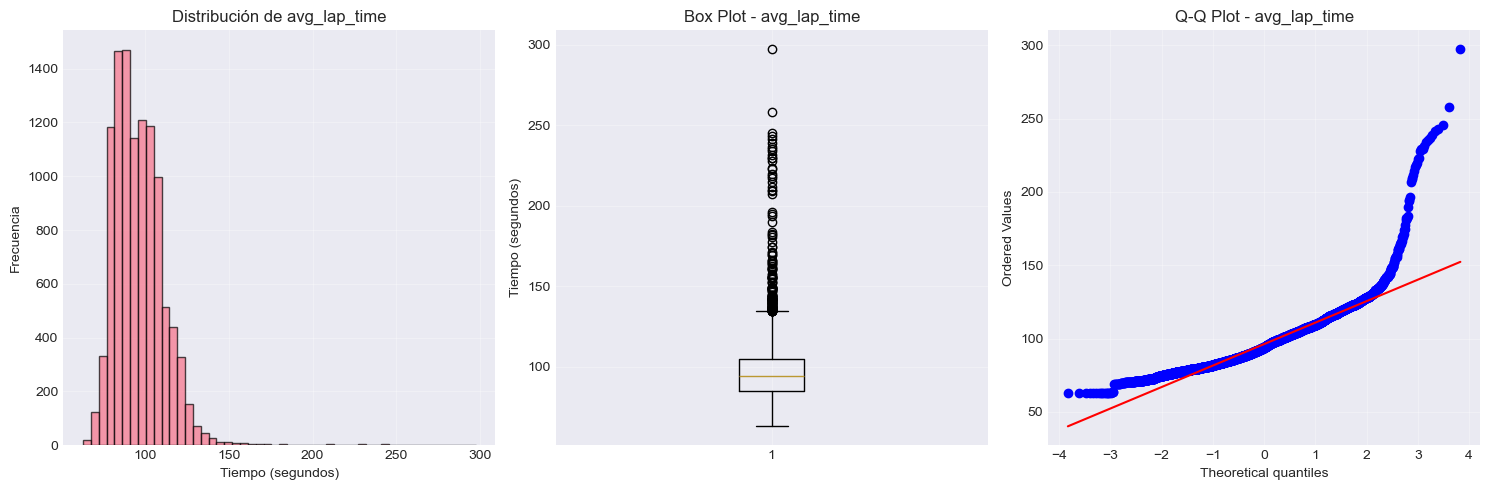


Estadísticas de avg_lap_time:
  count: 10788.000
  mean: 96.281
  std: 15.578
  min: 62.932
  25%: 85.049
  50%: 94.005
  75%: 104.845
  max: 297.225

Test de Shapiro-Wilk (normalidad):
  Estadístico: 0.881199
  P-valor: 0.000000
  Interpretación: No distribución normal


In [51]:
# 11.1 Análisis de distribuciones para dataset de regresión
if 'regression_final' in datasets:
    print("ANÁLISIS DE DISTRIBUCIONES - DATASET DE REGRESIÓN")
    print("="*80)
    
    df_reg = datasets['regression_final']
    
    # Análisis de la variable target
    target = regression_target
    if target in df_reg.columns:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Histograma de tiempo promedio de vuelta
        axes[0].hist(df_reg[target].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[0].set_title(f'Distribución de {target}')
        axes[0].set_xlabel('Tiempo (segundos)')
        axes[0].set_ylabel('Frecuencia')
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        axes[1].boxplot(df_reg[target].dropna())
        axes[1].set_title(f'Box Plot - {target}')
        axes[1].set_ylabel('Tiempo (segundos)')
        axes[1].grid(True, alpha=0.3)
        
        # Q-Q plot para normalidad
        from scipy import stats
        stats.probplot(df_reg[target].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title(f'Q-Q Plot - {target}')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas descriptivas
        print(f"\nEstadísticas de {target}:")
        stats_desc = df_reg[target].describe()
        for stat, value in stats_desc.items():
            print(f"  {stat}: {value:.3f}")
        
        # Test de normalidad
        shapiro_stat, shapiro_p = stats.shapiro(df_reg[target].dropna().sample(min(5000, len(df_reg))))
        print(f"\nTest de Shapiro-Wilk (normalidad):")
        print(f"  Estadístico: {shapiro_stat:.6f}")
        print(f"  P-valor: {shapiro_p:.6f}")
        print(f"  Interpretación: {'Distribución normal' if shapiro_p > 0.05 else 'No distribución normal'}")


ANÁLISIS DE CORRELACIONES - REGRESIÓN
------------------------------------------------------------

Top 10 correlaciones con avg_lap_time:
  q3_seconds: 0.779
  best_qualifying_time: 0.769
  avg_qualifying_time: 0.762
  q1_seconds: 0.754
  q2_seconds: 0.740
  lng: 0.335
  alt: 0.208
  raceId: 0.115
  avg_position_last_3: 0.107
  qualifying_position: 0.094


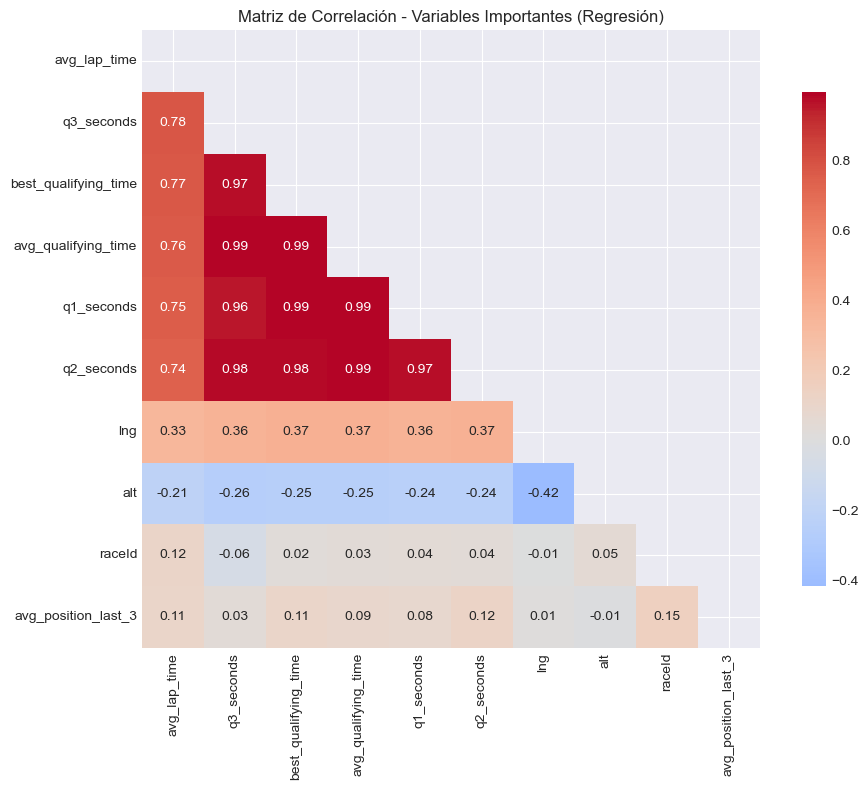

In [52]:
# 11.2 Análisis de correlaciones en dataset de regresión
if 'regression_final' in datasets:
    print("\nANÁLISIS DE CORRELACIONES - REGRESIÓN")
    print("-" * 60)
    
    df_reg = datasets['regression_final']
    
    # Seleccionar solo variables numéricas
    numeric_cols = df_reg.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_cols) > 1:
        # Calcular correlaciones con el target
        target_correlations = df_reg[numeric_cols].corr()[regression_target].abs().sort_values(ascending=False)
        
        print(f"\nTop 10 correlaciones con {regression_target}:")
        for var, corr in target_correlations.head(11).items():  # 11 porque incluye el target consigo mismo
            if var != regression_target:
                print(f"  {var}: {corr:.3f}")
        
        # Matriz de correlación de variables más importantes
        important_vars = target_correlations.head(10).index.tolist()
        if regression_target not in important_vars:
            important_vars.append(regression_target)
        
        corr_matrix = df_reg[important_vars].corr()
        
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                   cmap='coolwarm', center=0, square=True,
                   cbar_kws={"shrink": 0.8})
        plt.title('Matriz de Correlación - Variables Importantes (Regresión)')
        plt.tight_layout()
        plt.show()


ANÁLISIS DE DISTRIBUCIONES - DATASET DE CLASIFICACIÓN


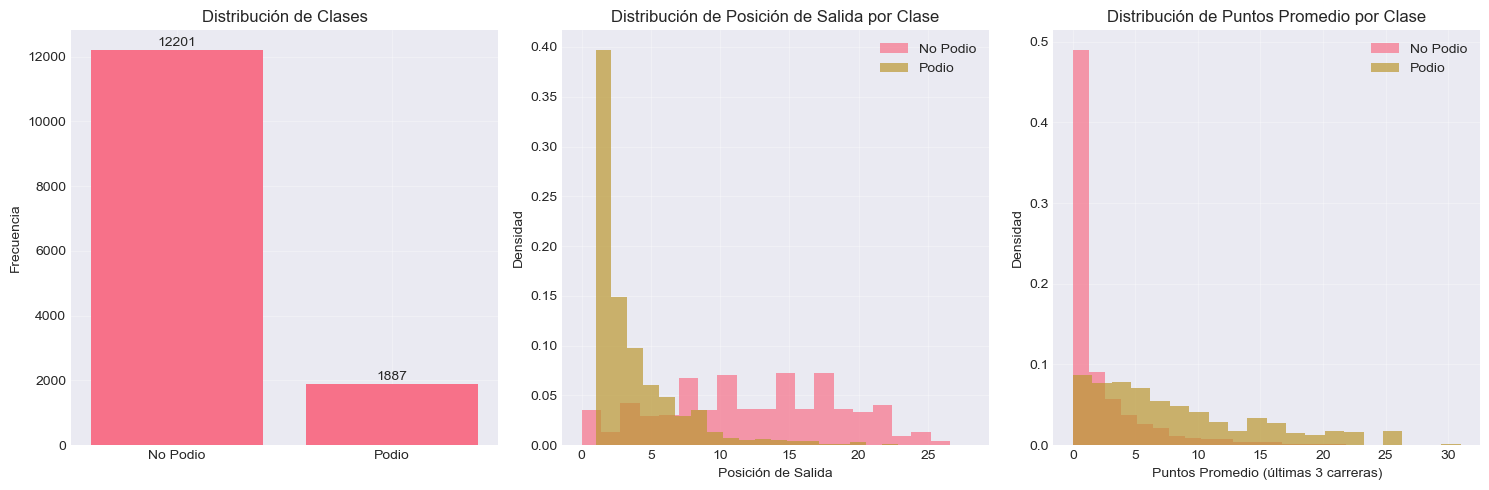


Estadísticas por clase:
         grid        avg_points_last_3        driver_race_count        
         mean median              mean median              mean  median
podium                                                                 
0      12.255 12.000             2.007  0.333            82.337  58.000
1       3.700  3.000             8.294  6.667           126.911 122.000


In [53]:
# 11.3 Análisis de distribuciones para dataset de clasificación
if 'classification_final' in datasets:
    print("\nANÁLISIS DE DISTRIBUCIONES - DATASET DE CLASIFICACIÓN")
    print("="*80)
    
    df_class = datasets['classification_final']
    
    # Análisis de la variable target (podio)
    target = classification_target
    if target in df_class.columns:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Distribución de clases
        class_counts = df_class[target].value_counts()
        axes[0].bar(['No Podio', 'Podio'], [class_counts[0], class_counts[1]])
        axes[0].set_title('Distribución de Clases')
        axes[0].set_ylabel('Frecuencia')
        axes[0].grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, v in enumerate([class_counts[0], class_counts[1]]):
            axes[0].text(i, v + max(class_counts) * 0.01, str(v), ha='center')
        
        # Distribución de posición de salida por clase
        if 'grid' in df_class.columns:
            podium_grid = df_class[df_class[target] == 1]['grid']
            no_podium_grid = df_class[df_class[target] == 0]['grid']
            
            axes[1].hist(no_podium_grid, bins=20, alpha=0.7, label='No Podio', density=True)
            axes[1].hist(podium_grid, bins=20, alpha=0.7, label='Podio', density=True)
            axes[1].set_title('Distribución de Posición de Salida por Clase')
            axes[1].set_xlabel('Posición de Salida')
            axes[1].set_ylabel('Densidad')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        # Distribución de puntos históricos por clase
        if 'avg_points_last_3' in df_class.columns:
            podium_points = df_class[df_class[target] == 1]['avg_points_last_3'].dropna()
            no_podium_points = df_class[df_class[target] == 0]['avg_points_last_3'].dropna()
            
            axes[2].hist(no_podium_points, bins=20, alpha=0.7, label='No Podio', density=True)
            axes[2].hist(podium_points, bins=20, alpha=0.7, label='Podio', density=True)
            axes[2].set_title('Distribución de Puntos Promedio por Clase')
            axes[2].set_xlabel('Puntos Promedio (últimas 3 carreras)')
            axes[2].set_ylabel('Densidad')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas por clase
        print(f"\nEstadísticas por clase:")
        class_stats = df_class.groupby(target).agg({
            'grid': ['mean', 'median'],
            'avg_points_last_3': ['mean', 'median'],
            'driver_race_count': ['mean', 'median']
        }).round(3)
        
        print(class_stats)

## 12. Resumen del Preprocesamiento y Guardado

In [54]:
# 12.1 Resumen completo del preprocesamiento
print("RESUMEN COMPLETO DEL PREPROCESAMIENTO")
print("=" * 80)

print("\n1. DATASETS PROCESADOS:")
print("-" * 40)
for name, df in datasets.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {name}: {len(df):,} registros × {df.shape[1]} columnas")

print("\n2. PROCESOS APLICADOS:")
print("-" * 40)
processes = [
    "✓ Carga de 11 datasets principales",
    "✓ Limpieza de datos (posiciones, tiempos, valores extremos)",
    "✓ Manejo de valores faltantes con KNN Imputer",
    "✓ Detección y eliminación de duplicados",
    "✓ Feature engineering (estadísticas históricas, rendimiento por circuito)",
    "✓ Unión de tablas en dataset maestro",
    "✓ Codificación de variables categóricas (Label + One-Hot Encoding)",
    "✓ Creación de datasets específicos para cada modelo",
    "✓ Análisis de distribuciones y correlaciones"
]

for process in processes:
    print(f"  {process}")

print("\n3. DATASETS FINALES PARA MODELADO:")
print("-" * 40)
if 'regression_final' in datasets:
    df_reg = datasets['regression_final']
    print(f"  REGRESIÓN:")
    print(f"    - Registros: {len(df_reg):,}")
    print(f"    - Features: {df_reg.shape[1] - 1}")
    print(f"    - Target: {regression_target}")
    print(f"    - Completitud promedio: {((df_reg.notna().sum().sum() / (df_reg.shape[0] * df_reg.shape[1])) * 100):.1f}%")

if 'classification_final' in datasets:
    df_class = datasets['classification_final']
    podium_rate = (df_class[classification_target].sum() / len(df_class)) * 100
    print(f"\n  CLASIFICACIÓN:")
    print(f"    - Registros: {len(df_class):,}")
    print(f"    - Features: {df_class.shape[1] - 1}")
    print(f"    - Target: {classification_target}")
    print(f"    - Tasa de podio: {podium_rate:.2f}%")
    print(f"    - Completitud promedio: {((df_class.notna().sum().sum() / (df_class.shape[0] * df_class.shape[1])) * 100):.1f}%")

print("\n4. CALIDAD DE DATOS:")
print("-" * 40)
quality_indicators = [
    "✓ Valores extremos filtrados en tiempos de vuelta",
    "✓ Posiciones especiales convertidas a valores numéricos",
    "✓ Variables categóricas codificadas apropiadamente",
    "✓ Features de rendimiento histórico sin data leakage",
    "✓ Balance de clases identificado para clasificación",
    "✓ Correlaciones analizadas para detección de multicolinealidad"
]

for indicator in quality_indicators:
    print(f"  {indicator}")

RESUMEN COMPLETO DEL PREPROCESAMIENTO

1. DATASETS PROCESADOS:
----------------------------------------
  race_results: 26,519 registros × 21 columnas
  qualifying_results: 10,254 registros × 14 columnas
  lap_timings: 574,337 registros × 7 columnas
  driver_details: 859 registros × 11 columnas
  team_details: 212 registros × 5 columnas
  race_schedule: 1,125 registros × 18 columnas
  track_information: 77 registros × 9 columnas
  pit_stop_records: 10,990 registros × 7 columnas
  driver_rankings: 34,595 registros × 7 columnas
  constructor_rankings: 13,271 registros × 7 columnas
  race_status: 139 registros × 2 columnas
  lap_statistics: 10,788 registros × 10 columnas
  race_results_enhanced: 26,519 registros × 29 columnas
  constructor_yearly_stats: 920 registros × 7 columnas
  race_results_circuit: 26,519 registros × 34 columnas
  master_dataset: 14,089 registros × 63 columnas
  regression_final: 10,788 registros × 43 columnas
  classification_final: 14,088 registros × 36 columnas

2

In [55]:
# 12.2 Guardado de datasets procesados
print("\nGUARDADO DE DATASETS PROCESADOS")
print("=" * 60)

import os

# Crear directorio de datos procesados si no existe
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Guardar datasets principales
datasets_to_save = {
    'master_dataset': 'master_dataset_f1.csv',
    'regression_final': 'f1_regression_ready.csv',
    'classification_final': 'f1_classification_ready.csv',
    'lap_statistics': 'lap_statistics_f1.csv'
}

for dataset_name, filename in datasets_to_save.items():
    if dataset_name in datasets:
        filepath = os.path.join(PROCESSED_PATH, filename)
        try:
            datasets[dataset_name].to_csv(filepath, index=False)
            print(f"[OK] {filename} guardado ({len(datasets[dataset_name]):,} registros)")
        except Exception as e:
            print(f"[ERROR] {filename}: {e}")

# Guardar información de las variables para referencia
feature_info = {
    'regression_features': available_regression_features,
    'classification_features': available_classification_features,
    'regression_target': regression_target,
    'classification_target': classification_target,
    'encoders_used': list(encoders.keys()) if 'encoders' in locals() else []
}

import json
with open(os.path.join(PROCESSED_PATH, 'preprocessing_info.json'), 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"[OK] preprocessing_info.json guardado")

print(f"\nTodos los archivos guardados en: {PROCESSED_PATH}")
print("\nDATOS PREPROCESADOS COMPLETADOS")
print("=" * 60)
print("Los datos han sido completamente preprocesados y están listos para:")
print("1. Análisis exploratorio avanzado")
print("2. Modelado de regresión (predicción de tiempo de vuelta)")
print("3. Modelado de clasificación (predicción de podio)")
print("4. Validación y evaluación de modelos")


GUARDADO DE DATASETS PROCESADOS
[OK] master_dataset_f1.csv guardado (14,089 registros)
[OK] f1_regression_ready.csv guardado (10,788 registros)
[OK] f1_classification_ready.csv guardado (14,088 registros)
[OK] lap_statistics_f1.csv guardado (10,788 registros)
[OK] preprocessing_info.json guardado

Todos los archivos guardados en: ../data/02_intermediate/

DATOS PREPROCESADOS COMPLETADOS
Los datos han sido completamente preprocesados y están listos para:
1. Análisis exploratorio avanzado
2. Modelado de regresión (predicción de tiempo de vuelta)
3. Modelado de clasificación (predicción de podio)
4. Validación y evaluación de modelos
